# Sampling from the Learned Distrubtion

This notebook, shows how to sample from the learned distribution of solutions with the trained neural networks.

First prepare the dataset for sampling. The class `DataFiles`  used to organize the dataset, please refer to `generate_dataset.ipynb` and `process_dataset.ipynb`

In [1]:
# run this cell to install the required packages and clone the repository if you are using colab
%pip install einops bayesian_torch
!git init
!git clone https://github.com/Slate452/Diffusion-based-Flow-Prediction.git
%cd Diffusion-based-Flow-Prediction/

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 4.4 MB/s eta 0:00:00
hint: Using 'master' as the name for the initial branch. This default branch name
hint: is subject to change. To configure the initial branch name to use in all
hint: of your new repositories, which will suppress this warning, call:
hint: 
hint: 	git config --global init.defaultBranch <name>
hint: 
hint: Names commonly chosen instead of 'master' are 'main', 'trunk' and
hint: 'development'. The just-created branch can be renamed via this command:
hint: 
hint: 	git branch -m <name>
Initialized empty Git repository in /content/.git/
Cloning into 'Diffusion-based-Flow-Prediction'...
remote: Enumerating objects: 320, done.
remote: Counting objects: 100% (70/70), done.
remote: Compressing objects: 100% (35/35), done.
remote: Total 320 (delta 43), reused 48 (delta 29), pack-reused 250 (from 1)
Receiving objects: 100% (320/320), 773.80 MiB | 16.33 MiB/s, done.
Resolving deltas: 100% (112/112), done.
Updating files: 1

In [2]:
import zipfile
import torch
from airfoil_diffusion.airfoil_datasets import *
from airfoil_diffusion.networks import *
from airfoil_diffusion.trainer import *
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

if not os.path.exists("./datasets/1_parameter/data/"):
    files=[file for file in os.listdir("./datasets/1_parameter/") if file.endswith(".zip")]
    for file in tqdm(files):
        f=zipfile.ZipFile("./datasets/1_parameter/"+file,'r')
        for file in f.namelist():
            f.extract(file,"./datasets/1_parameter/data/")
        f.close()

df_train=FileDataFiles("./datasets/1_parameter/train_cases.txt",base_path="./datasets/1_parameter/data/")
df_test=FileDataFiles("./datasets/1_parameter/test_cases.txt",base_path="./datasets/1_parameter/data/")
df_all=DataFiles(df_train.case_list+df_test.case_list)

100%|██████████| 11/11 [00:01<00:00,  6.98it/s]


The test dataset consists of 6 simulations with raf30 airfoil. The angle of attack is 20 $\degree$ and the $Re$ ranges from $0.5 \times 10^6$ to $10.5 \times 10^6$. Let's first have a look at how the ground truth mean field and the standard deviation of these simulation cases look like:

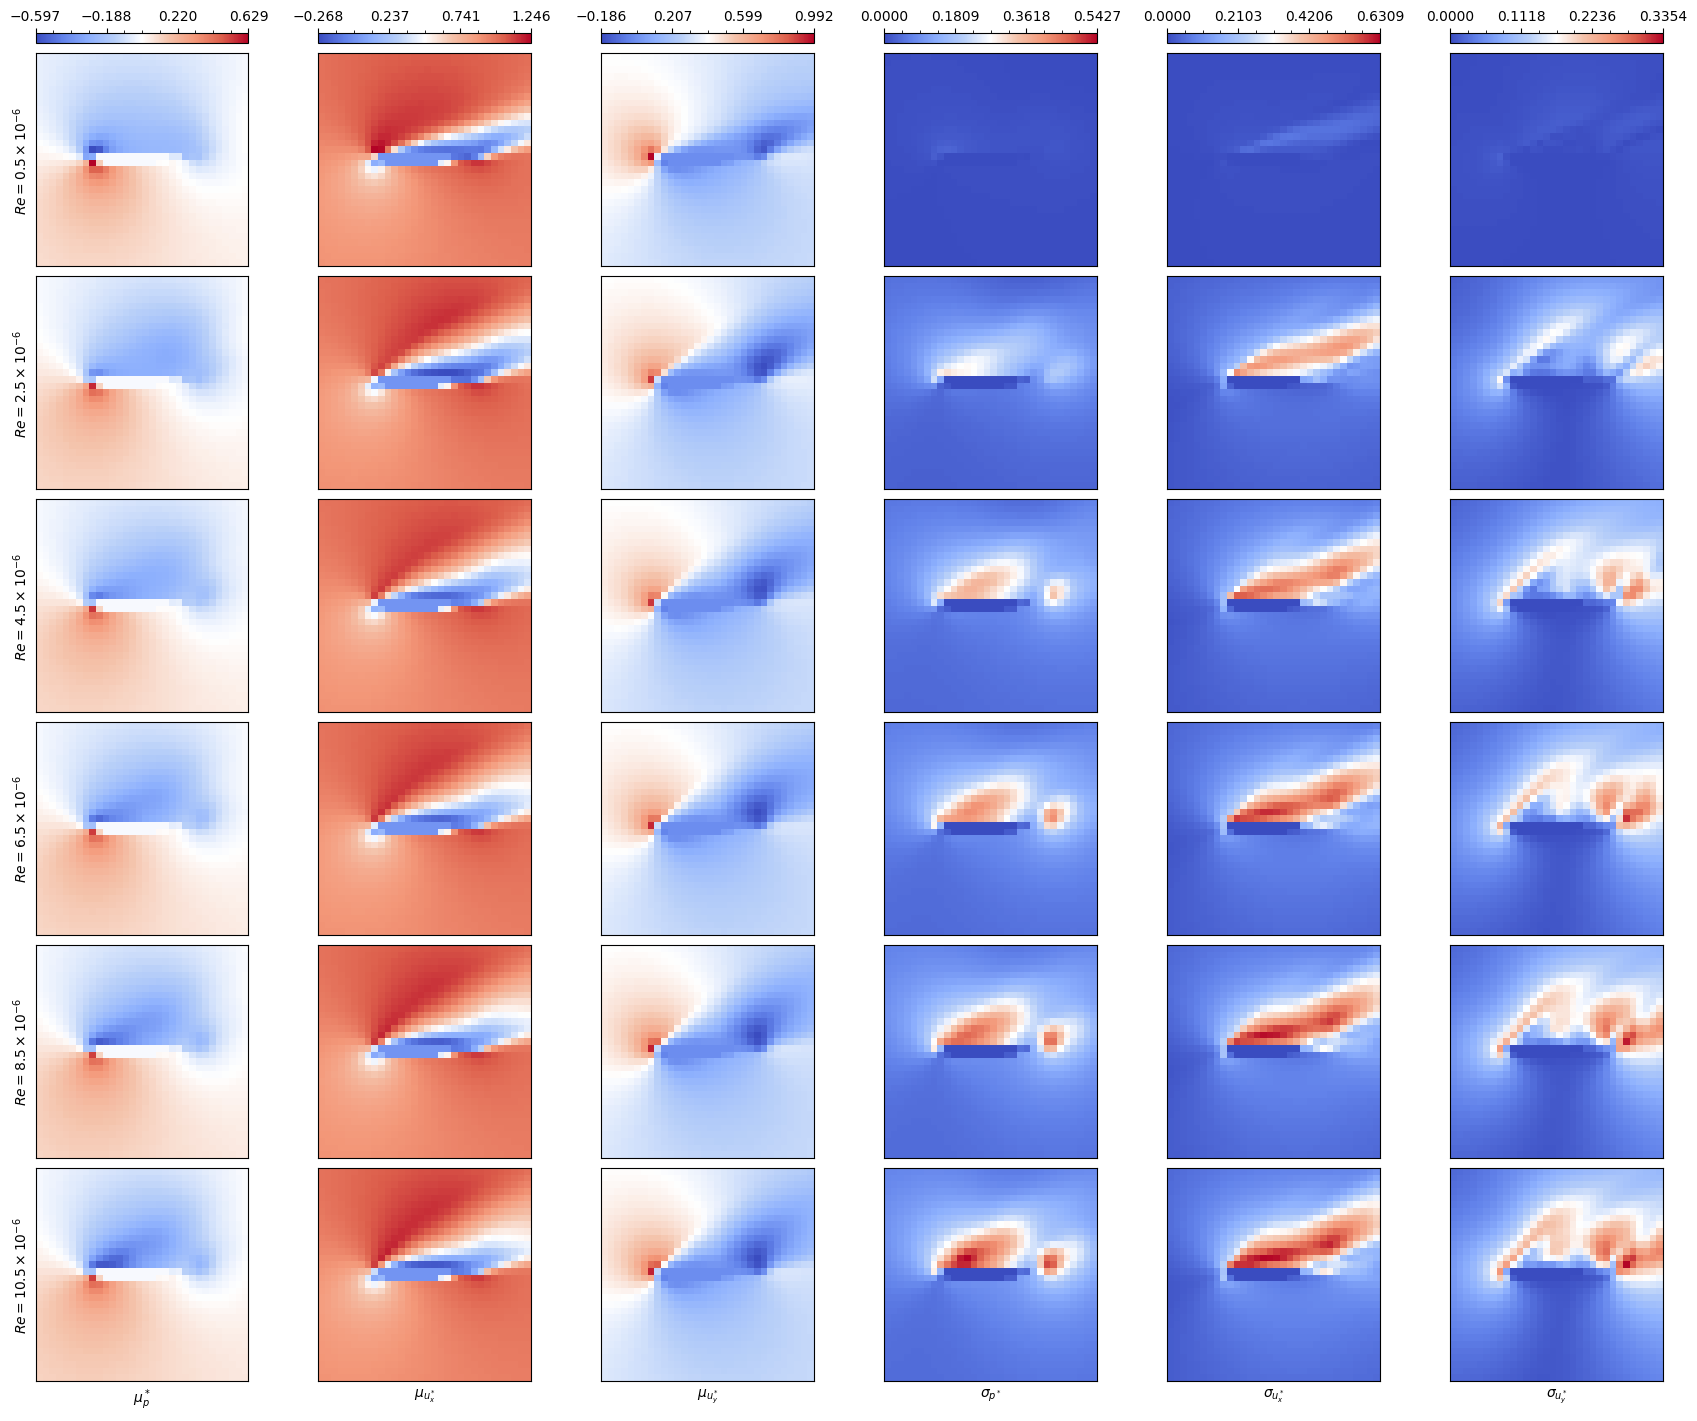

In [23]:
df_test.sort()
std_field_test_gd=[]
mean_field_test_gd=[]
inputs_test=[]
samples_gd=[]
for case in df_test.get_simulation_cases():
    datas=[]
    selected_cases=df_test.select_simulation_cases([case])
    for case in selected_cases:
        raw_data=read_single_file(case['path']+case['file_name'],model="dimless",scale_factor=0.25)
        datas.append(
            raw_data[3:]
            )
    inputs_test.append(read_single_file(case['path']+case['file_name'],model="normalized",scale_factor=0.25)[0:3])
    samples_gd.append(np.stack(datas,axis=0))
    std_field_test_gd.append(samples_gd[-1].std(axis=0))
    mean_field_test_gd.append(samples_gd[-1].mean(axis=0))
std_field_test_gd=np.stack(std_field_test_gd,axis=0)
mean_field_test_gd=np.stack(mean_field_test_gd,axis=0)

from airfoil_diffusion.plotter import *
CHANNEL_NAME_MEAN=[r"$\mu_p^*$",r"$\mu_{u_x^*}$",r"$\mu_{u_y^*}$"]
CHANNEL_NAME_STD=[r"$\sigma_{p^*}$",r"$\sigma_{u_x^*}$",r"$\sigma_{u_y^*}$"]
show_each_channel(np.concatenate([mean_field_test_gd,std_field_test_gd],axis=1),
                  channel_names=CHANNEL_NAME_MEAN+CHANNEL_NAME_STD,
                  case_names=[r"$Re={}\times$".format(0.5 +2*i)+"$10^{-6}$" for i in range(6)],transpose=True,inverse_y=True)

We can use different models to predict these mean and standard deviation distributions.

For the diffusion model, the neural network predicts the noise during the diffusion procedure. Thus, we need an additional `diffuser` to sample the final solutions. Since each sample of the diffusion model represents a sample from the original simulation distribution, we need to do multiple samples to get the average and the standard deviation distribution:

In [4]:
def sample_diffusion(network,input_field,num_diffusion_sample=100):
    network.eval();network.to(device);predictions=[]
    batch_size=25;N_all=num_diffusion_sample
    diffuser=Cos2ParamsDiffuser(200,device=device)
    while True:
        if N_all<=0:
            break
        if N_all<batch_size:
            batch_size_now=N_all
            N_all=0
        else:
            N_all-=batch_size
            batch_size_now=batch_size
        prediction_batch=normalized2dimless(diffuser.sample_from_noise(network,input_field.to(device).repeat(batch_size_now,1,1,1),show_progress=False))
        predictions.append(prediction_batch.detach().cpu().numpy())
    predictions=np.concatenate(predictions,axis=0)
    return np.mean(predictions,axis=0),np.std(predictions,axis=0),predictions

Now, To Sample from Models Traineed Using different Conditioning Mechanisms

1.   No Conditional Cross Attention
2.   Conditional Cross Attention No Outside Shape Guidance

Models to add
3.   Conditional Cross Attention with Outside Shape Guidance (Attention Masking)
4.   No Conditional Cross Attention with Outside Shape Guidance (Attention Masking)

In [ ]:
index=3

input_field=inputs_test[index].unsqueeze(0)

dif_network=AifNet("./pre_trained/single_parameter/32/diffusion/network_configs.yaml") #No coditional attention
nm_1ca2sa = AifNet("./Test_Models/No_masking/1ca2sa_layers/network_configs.yaml") #Conditional attention with no masking
#m_1ca2sa = AifNet("./Test_Models/Masking/1ca2sa_layers/configs.yaml")
nm_1ca2sa.load_state_dict(torch.load("./Test_Models/No_masking/1ca2sa_layers/trained_network_weights.pt"))
dif_network.load_state_dict(torch.load("./pre_trained/single_parameter/32/diffusion/weights_0.pt"))
mean,std,samples_diffusion=sample_diffusion(dif_network,input_field,num_diffusion_sample=100)
mean_nm_1ca2sa,std_nm_1ca2sa,samples_diffusion_nm_n1ca2sa=sample_diffusion(nm_1ca2sa,input_field,num_diffusion_sample=100)
result_diffusion=np.concatenate([mean,std],axis=0)
result_diffusion_nm_1ca2sa=np.concatenate([mean_nm_1ca2sa,std_nm_1ca2sa],axis=0)


#Quantitative comparisons.

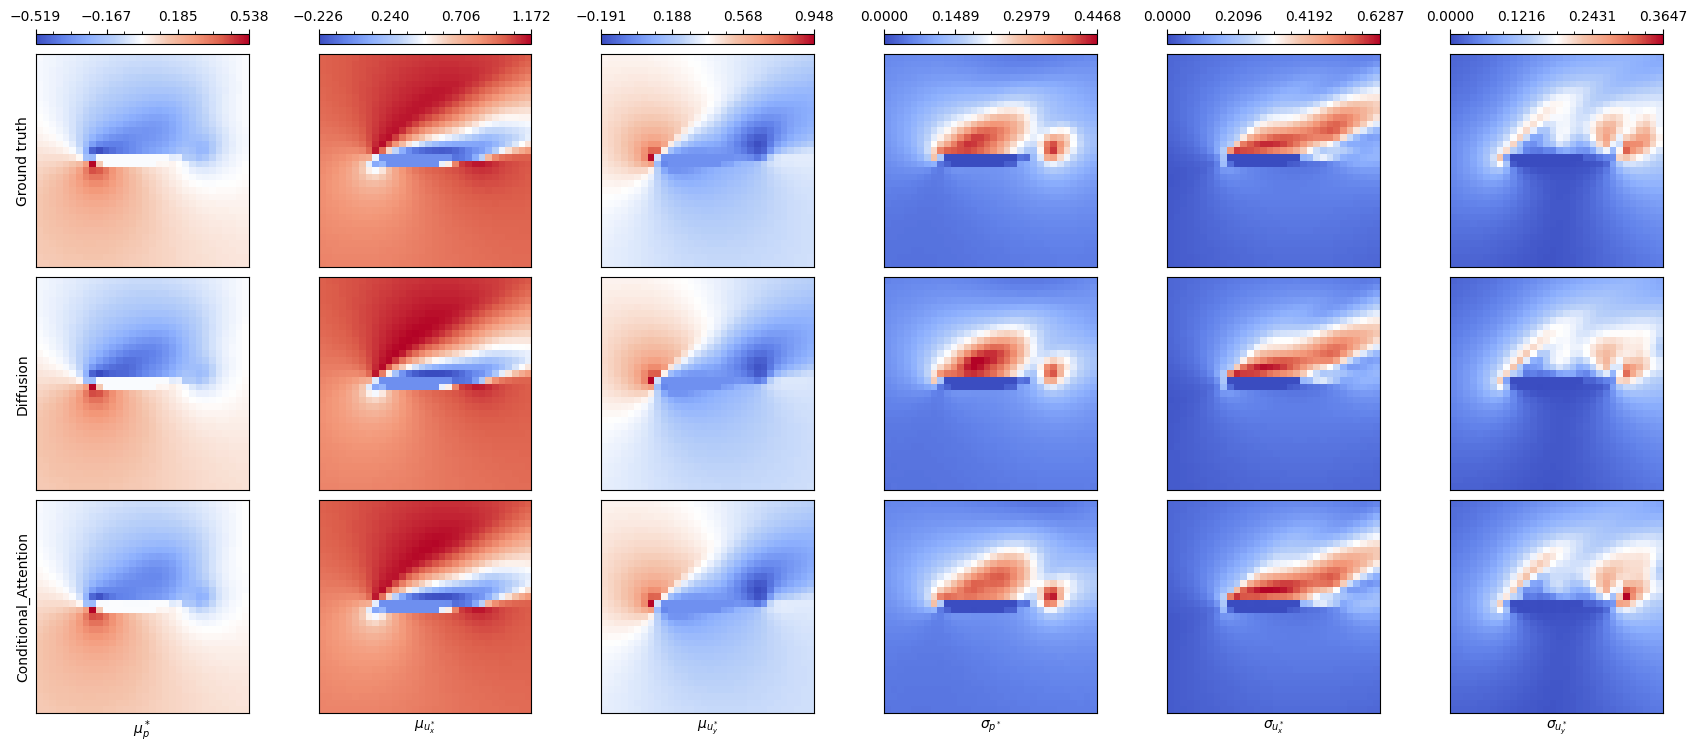

In [7]:
result_ground_truth=np.concatenate([mean_field_test_gd[index],std_field_test_gd[index]],axis=0)
show_each_channel([result_ground_truth,result_diffusion, result_diffusion_nm_1ca2sa],
                  channel_names=CHANNEL_NAME_MEAN+CHANNEL_NAME_STD,
                  case_names=["Ground truth","Diffusion", "Conditional_Attention"],transpose=True,inverse_y=True)

# Step 1: Compute the errors

In [59]:
p_samples_diffusion = torch.tensor(result_diffusion)
p_samples_gd = torch.tensor(result_ground_truth)
p_samples_diffusion_nm_1ca2sa = torch.tensor(result_diffusion_nm_1ca2sa)
error_diffusion = torch.abs(p_samples_diffusion - p_samples_gd)
error_diffusion_nm_1ca2sa = torch.abs(p_samples_diffusion_nm_1ca2sa - p_samples_gd)



# Step 2: Plot the errors

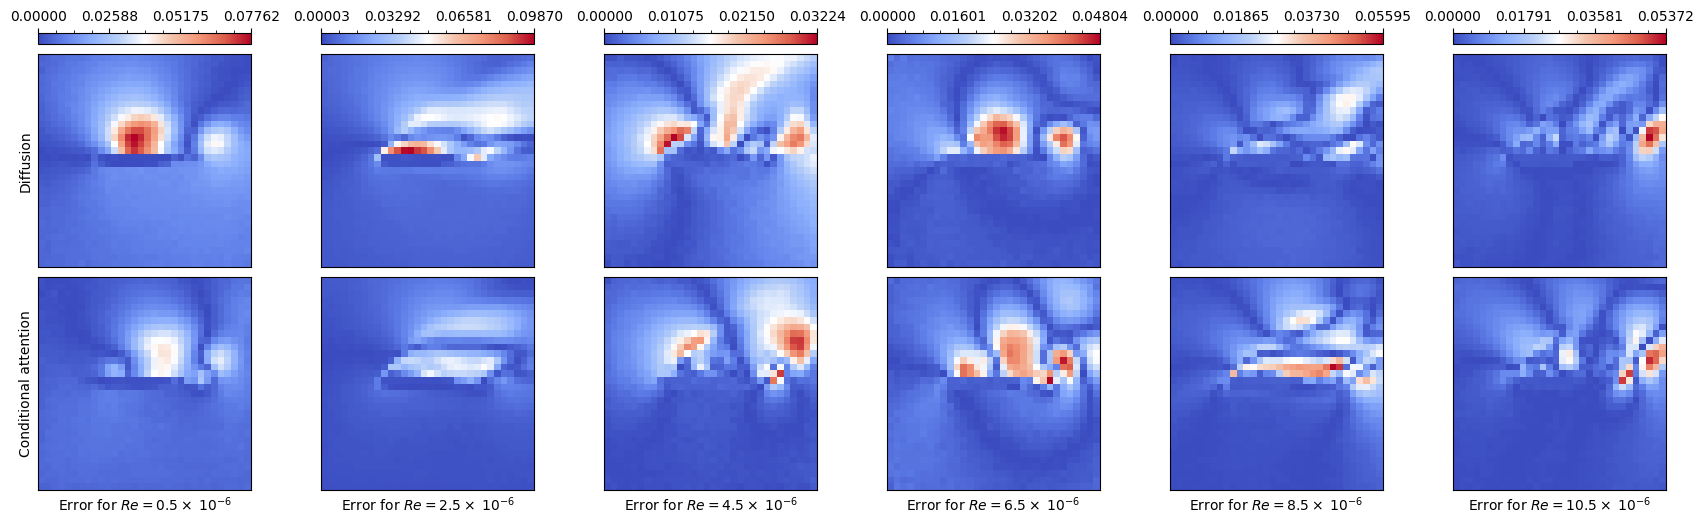

In [67]:
show_each_channel(
    [error_diffusion, error_diffusion_nm_1ca2sa],
    channel_names=CHANNEL_NAME_MEAN+CHANNEL_NAME_STD,
    case_names=["Diffusion", "Conditional attention"],
    transpose=True, inverse_y=True
)

# Step 3: Plot Averaged errors for 100 samples errors

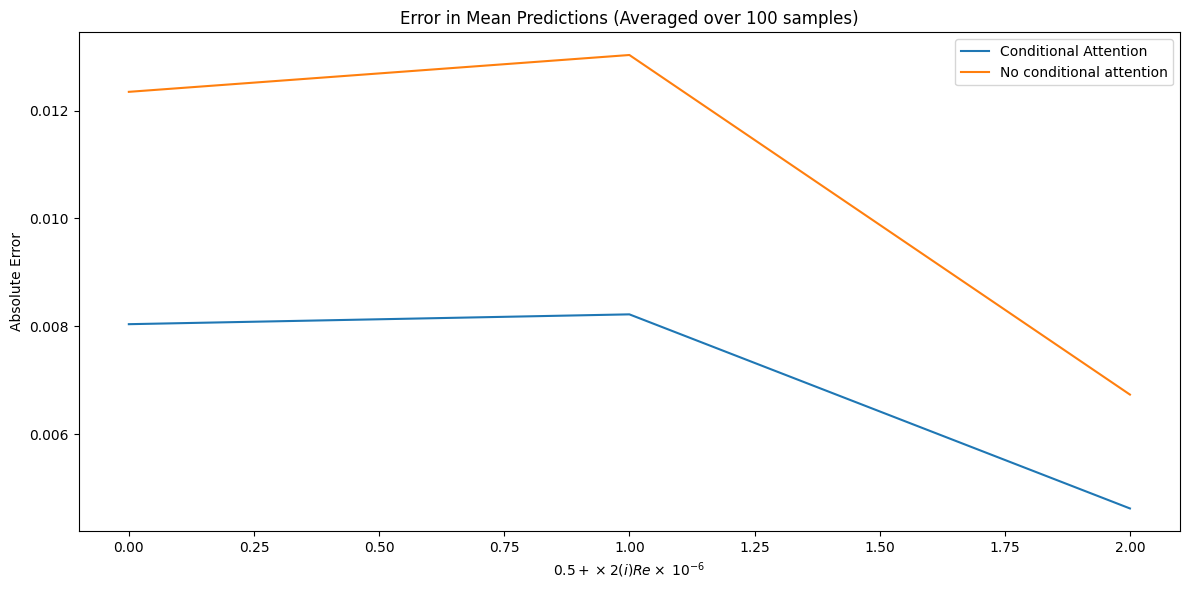

In [75]:
error_mean = torch.abs(torch.tensor(mean_field_test_gd[index]) - torch.tensor(mean_nm_1ca2sa))
error_std = torch.abs(torch.tensor(std_field_test_gd[index]) - torch.tensor(std_nm_1ca2sa))
error_mean_dif = torch.abs(torch.tensor(mean_field_test_gd[index]) - torch.tensor(mean))
error_std_dif = torch.abs(torch.tensor(std_field_test_gd[index]) - torch.tensor(std))
error_mean_np = error_mean.cpu().numpy()
error_std_np = error_std.cpu().numpy()
error_mean_dif_np = error_mean_dif.cpu().numpy()
error_std_dif_np = error_std_dif.cpu().numpy()
error_mean_avg = error_mean_np.mean(axis=(1, 2))
error_std_avg = error_std_np.mean(axis=(1, 2))
fig, ax = plt.subplots(1,1, figsize=(12, 6))
ax.plot(error_mean_avg, label='Conditional Attention')
ax.plot(error_mean_dif_np.mean(axis=(1, 2)), label='No conditional attention')
ax.set_title('Error in Mean Predictions (Averaged over 100 samples)')
ax.set_xlabel(r"$0.5 + \times 2(i) Re\times$ $10^{-6}$")
ax.set_ylabel('Absolute Error')
ax.legend()
plt.tight_layout()
plt.show()

In [48]:
df_all.sort()
std_groundtruth=[]
mean_groundtruth=[]
for case in df_all.get_simulation_cases():
    datas=[]
    selected_cases=df_all.select_simulation_cases([case])
    for case in selected_cases:
        datas.append(
            read_single_file(case['path']+case['file_name'],model="dimless",scale_factor=0.25)[3:] # scale factor is 0.25 to geet 32 $\times$ 32 data
            )
    std_groundtruth.append(np.stack(datas,axis=0).std(axis=0).mean())
    mean_groundtruth.append(np.mean(datas,axis=(1,2,3)))

By performing the sampling on the whole test dataset, we can compare our predictions with the ground truth:

In [9]:
def do_test(sample_func):
    mean_predictions=[]
    std_predictions=[]
    std_a_predictions=[]
    for input_field in tqdm(inputs_test):
        mean_fields,std_fields,_=sample_func(input_field.unsqueeze(0))
        mean_predictions.append(mean_fields)
        std_predictions.append(std_fields)
        std_a_predictions.append(np.mean(std_fields))
    return mean_predictions,std_predictions,std_a_predictions

In [ ]:
mean_predictions_dif,std_predictions_dif,std_a_predictions_dif=do_test(lambda x:sample_diffusion(dif_network,x,num_diffusion_sample=500));
mean_predictions_nm_1ca2sa,std_predictions_nm_1ca2sa,std_a_predictions_nm_1ca2sa=do_test(lambda x:sample_diffusion(nm_1ca2sa,x,num_diffusion_sample=500))

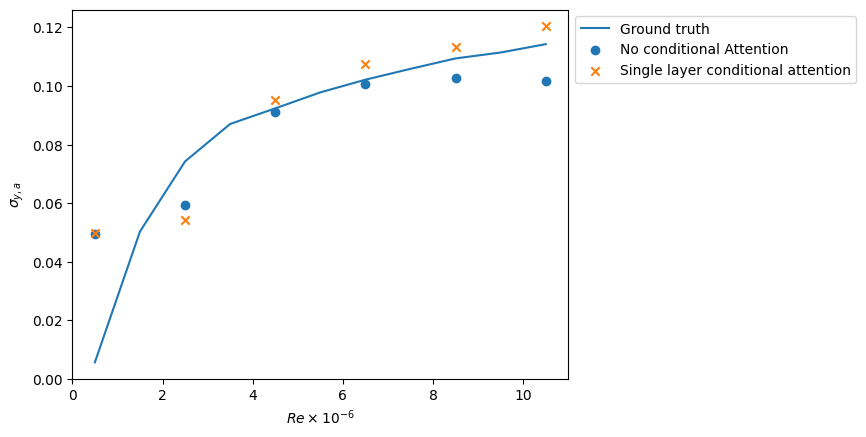

In [43]:
x=[0.5 +2*i for i in range(6)]
plt.plot([0.5 +i for i in range(11)],std_groundtruth,label="Ground truth")
plt.scatter(x,std_a_predictions_dif,label="No conditional Attention",marker="o")
plt.scatter(x,std_a_predictions_nm_1ca2sa,label="Single layer conditional attention",marker="x")
plt.legend(bbox_to_anchor=(1.0,1.0))
plt.xlabel(r"$Re \times 10^{-6}$")
plt.ylabel(r"$\sigma_{y,a}$")
plt.show()